In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/Capstone_SpotifyStreaming/notebooks



In [1]:

import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

#from library.sb_utils import save_file


In [2]:
# load the feature matrix to check whether it was properly saved.

feature_matrix = pd.read_csv('../data/processed/feature_matrix_skip_processed.csv')
feature_matrix.head().T

,0,1,2,3,4
Unnamed: 0,0,10000,20000,30000,40000
event_id,0,1,2,3,4
session_id,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e
session_position,1,2,3,4,5
skip_1,False,False,False,False,False
...,...,...,...,...,...
DIFF(tf.time_signature_5) by session_id_not_skipped,NaN,NaN,0.0,0.0,0.0
DIFF(tf.us_popularity_estimate) by session_id,NaN,-0.071405,0.103248,-0.004938,0.00346
DIFF(tf.us_popularity_estimate) by session_id_not_skipped,NaN,NaN,-0.071405,0.103248,-0.004938
DIFF(tf.valence) by session_id,NaN,0.184898,0.03671,0.275558,0.003501


In [3]:
feature_matrix.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('bool'), dtype('float64')],
      dtype=object)

In [4]:
feature_matrix.columns[feature_matrix.dtypes=='O']

Index(['session_id', 'session_id_not_skipped'], dtype='object')

In [5]:
# remove the rows containing NaN, as they are the first few skipped tracks in a session
feature_matrix.drop(columns=['session_id_not_skipped'],inplace=True)
#feature_matrix.dropna(inplace=True)

In [6]:
feature_matrix.shape

(167880, 741)

# Train/test data split

In this case ,there are 3 ways of splitting the data.


1.   **Randomly split the data by row, regardless the session and order information.** This is the most conventional approach.
2.   **Extract the last few tracks of each session as test dataset.** This approach focuses on whether the model can predict the next track being skipped according to its preceeding history.
3.   **Randomly select all the rows of a few sessions as test dataset.** This approach focuses on whether the listening behavior is generalizable to different sessions.





# Random split

In [7]:
# the function of integrating the skipping labels into one column
def skip_label(df):
    skip = (df['not_skipped']==False).astype(int)*4 # no skip: 0, ultra-late skip: 4
    # It has to go under this order. If skip_1 = True, then skip_2 and _3 will be True too.
    skip[df['skip_3']==True] = 3 # late skip
    skip[df['skip_2']==True] = 2 # mid skip
    skip[df['skip_1']==True] = 1 # early skip
    return skip

In [8]:
skip = skip_label(feature_matrix)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(feature_matrix.drop(columns=['not_skipped', 'skip_1', 'skip_2', 'skip_3', 'session_id']), 
                                                    skip, test_size=0.2, 
                                                    random_state=47,stratify=skip )

In [10]:
print('X_train.shape: ',X_train.shape)
print('X_test.shape: ',X_test.shape)
print('y_train.shape: ',y_train.shape)
print('y_test.shape: ',y_test.shape)

X_train.shape:  (134304, 736)
X_test.shape:  (33576, 736)
y_train.shape:  (134304,)
y_test.shape:  (33576,)


In [11]:
X_test.head()

,Unnamed: 0,event_id,session_position,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_is_shuffle,hour_of_day,premium,...,DIFF(tf.time_signature_3) by session_id,DIFF(tf.time_signature_3) by session_id_not_skipped,DIFF(tf.time_signature_4) by session_id,DIFF(tf.time_signature_4) by session_id_not_skipped,DIFF(tf.time_signature_5) by session_id,DIFF(tf.time_signature_5) by session_id_not_skipped,DIFF(tf.us_popularity_estimate) by session_id,DIFF(tf.us_popularity_estimate) by session_id_not_skipped,DIFF(tf.valence) by session_id,DIFF(tf.valence) by session_id_not_skipped
144579,88609,144579,9,0,1,0,0,True,0,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.420154,-0.027021,0.042978,0.255973
134780,18025,134780,2,1,1,0,0,False,13,True,...,0.0,NaN,0.0,NaN,0.0,NaN,-1.039200,NaN,-0.179846,NaN
29726,118999,29726,13,0,1,0,0,False,15,True,...,0.0,0.0,1.0,0.0,0.0,0.0,-0.000035,0.004814,-0.152165,0.195484
27957,152674,27957,18,0,1,0,0,False,23,True,...,-1.0,NaN,1.0,NaN,0.0,NaN,-0.036758,NaN,0.442874,NaN
121520,161326,121520,19,0,1,0,0,False,21,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.002041,0.000254,-0.086903,-0.052488


In [12]:
y_test.head()

144579    1
134780    3
29726     0
27957     0
121520    1
Name: not_skipped, dtype: int64

In [14]:
skf = StratifiedKFold(n_splits=5)
skf

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

In [15]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=23)
)
rf_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=skf, verbose=1, n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  6.7min remaining: 10.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.7min finished


In [17]:
rf_cv_results

{'fit_time': array([395.83621502, 395.39602304, 394.67279196, 392.92897415,
        393.27807903]),
 'score_time': array([4.19183016, 4.45871782, 4.39804697, 4.62284184, 4.23748803]),
 'test_score': array([0.63757865, 0.64130152, 0.6443915 , 0.64148766, 0.64344751])}

In [18]:
RF_pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=23))])

In [19]:
score_train = RF_pipe.score(X_train,y_train)
score_test = RF_pipe.score(X_test,y_test)
print('score_train',score_train)
print('score_test',score_test)

score_train 0.9999851084107696
score_test 0.6420359780795807


In [20]:
y_test_pred = RF_pipe.predict(X_test)

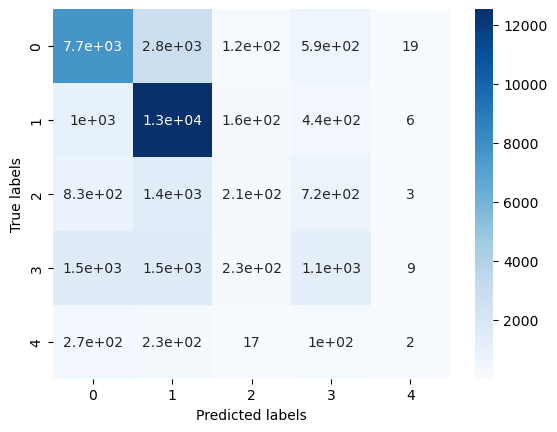

In [21]:
pl = confusion_matrix(y_test,y_test_pred)
ax= plt.subplot()
p=sns.heatmap(pl, annot=True,cmap ='Blues',ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.68      0.69      0.68     11177
           1       0.68      0.89      0.77     14152
           2       0.28      0.07      0.11      3212
           3       0.38      0.26      0.31      4406
           4       0.05      0.00      0.01       629

    accuracy                           0.64     33576
   macro avg       0.41      0.38      0.37     33576
weighted avg       0.59      0.64      0.60     33576



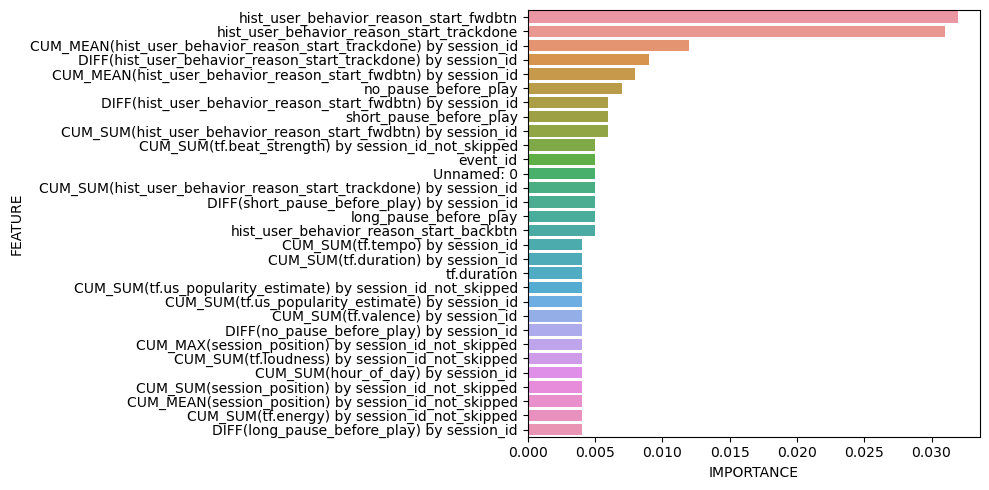

In [25]:
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train2 = imp_median.fit_transform(X_train)
forest = RandomForestClassifier(random_state=23, n_jobs = -1)
forest.fit(X_train2, y_train)

importances = pd.DataFrame({'FEATURE':X_train.columns,'IMPORTANCE':np.round(forest.feature_importances_,3)})
importances = importances.sort_values('IMPORTANCE',ascending=False).set_index('FEATURE')

fig, ax = plt.subplots(figsize=(10,5)) 
sel_range = 30
sns.barplot(y = importances[0:sel_range].index, x = importances['IMPORTANCE'][0:sel_range], orient = 'h', ax = ax)

plt.tight_layout()
plt.show()

**Hyperparameter tuning is necessary as it is clearly overfitting.**

In [ ]:
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, roc_auc_score

param_grid = {'n_estimators':np.arange(20,200,20), 
             'max_depth':[np.arange(2,22,2),None], 
             'class_weight': ['balanced', None]}
RF_MulClass_pt = RandomForestClassifier(random_state=23, n_jobs = -1)
rf_cv= GridSearchCV(RF_MulClass_pt,
                    param_grid,
                    cv=5, 
                    n_jobs = -1, 
                    scoring=['accuracy','balanced_accuracy','f1_weighted'],
                    refit='accuracy')
rf_cv.fit(X_train,y_train)


pd.DataFrame(rf_cv.cv_results_).to_csv('../models/simpleModel/RF_FeatureEngineering_GridSearchCV_20221117.csv')
from joblib import dump, load
dump(rf_cv, '../models/simpleModel/RF_FeatureEngineering_GridSearchCV_20221117.joblib') 

/Users/andrewchang/opt/anaconda3/envs/Springboard_DS_2022/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
pd.DataFrame(rf_cv.cv_results_)

In [ ]:
print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

In [ ]:
pd.DataFrame(rf_cv.cv_results_).sort_values('mean_test_f1_weighted')[['params','mean_test_f1_weighted','mean_test_accuracy','mean_test_balanced_accuracy']].head()

# Session split

In [40]:
s_list = feature_matrix['session_id'].unique()
len(s_list)

10000

In [100]:
import random
random.shuffle(s_list)

train_sessions = list(s_list[:8000])
test_sessions = list(s_list[8000:])
print(len(train_sessions))
print(len(test_sessions))

8000
2000


In [101]:
feature_matrix['session_id']

0         0_00006f66-33e5-4de7-a324-2d18e439fc1e
1         0_0000a72b-09ac-412f-b452-9b9e79bded8f
2         0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a
3         0_00016a3d-9076-4f67-918f-f29e3ce160dc
4         0_00018b58-deb8-4f98-ac5e-d7e01b346130
                           ...                  
167875    0_0eab7430-d291-4d57-9c92-ac7cb682f2c6
167876    0_0eac164c-f209-4590-8608-a56e67658952
167877    0_0eacbee7-9868-48a0-9ab0-f86069329f50
167878    0_0ead11fc-f32c-4eb4-8fc1-15b51432a404
167879    0_0eaeef5d-25e9-4429-bd55-af15d3604c9f
Name: session_id, Length: 167880, dtype: object

In [102]:
data_train = feature_matrix.loc[feature_matrix['session_id'].isin(train_sessions),:]
data_test = feature_matrix.loc[feature_matrix['session_id'].isin(test_sessions),:]

In [103]:
print(data_train.shape)
print(data_test.shape)

(134145, 741)
(33735, 741)


In [104]:
len(data_train['session_id'].unique())

8000

In [105]:
len(data_test['session_id'].unique())

2000

In [113]:
X_train = data_train.drop(columns=['not_skipped', 'skip_1', 'skip_2', 'skip_3', 'session_id', 'session_id_not_skipped'])
X_test = data_test.drop(columns=['not_skipped', 'skip_1', 'skip_2', 'skip_3', 'session_id', 'session_id_not_skipped'])

y_train = data_train['not_skipped']
y_test = data_test['not_skipped']

In [111]:
X_train.columns

Index(['event_id', 'session_position', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'premium', 'hist_user_behavior_reason_start_appload',
       ...
       'DIFF(tf.time_signature_3) by session_id',
       'DIFF(tf.time_signature_3) by session_id_not_skipped',
       'DIFF(tf.time_signature_4) by session_id',
       'DIFF(tf.time_signature_4) by session_id_not_skipped',
       'DIFF(tf.time_signature_5) by session_id',
       'DIFF(tf.time_signature_5) by session_id_not_skipped',
       'DIFF(tf.us_popularity_estimate) by session_id',
       'DIFF(tf.us_popularity_estimate) by session_id_not_skipped',
       'DIFF(tf.valence) by session_id',
       'DIFF(tf.valence) by session_id_not_skipped'],
      dtype='object', length=735)

In [115]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=23)
)
RF_pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=23))])

In [108]:
score_train = RF_pipe.score(X_train,y_train)
score_test = RF_pipe.score(X_test,y_test)
print('score_train',score_train)
print('score_test',score_test)

score_train 1.0
score_test 1.0


In [109]:
importances = pd.DataFrame({'FEATURE':X_train.columns,'IMPORTANCE':np.round(RF_pipe.feature_importances_,3)})
importances = importances.sort_values('IMPORTANCE',ascending=False).set_index('FEATURE')

fig, ax = plt.subplots(figsize=(10,5)) 

sns.barplot(y = importances[0:sel_range].index, x = importances['IMPORTANCE'][0:sel_range], orient = 'h', ax = ax)

plt.tight_layout()
plt.show()

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

# Split within each sequence

In [162]:
data_train_append = []
data_test_append = []
for s_id in s_list:
    temp = []
    temp = feature_matrix.loc[feature_matrix['session_id']==s_id,:]
    data_train_append.append(temp.iloc[0:-4,:])
    data_test_append.append(temp.iloc[-4:,:])

data_train = pd.concat(data_train_append)
data_test = pd.concat(data_test_append)



In [163]:
print(data_test.shape)

(40000, 741)


In [164]:
X_train = data_train.drop(columns=['not_skipped', 'skip_1', 'skip_2', 'skip_3', 'session_id', 'session_id_not_skipped'])
X_test = data_test.drop(columns=['not_skipped', 'skip_1', 'skip_2', 'skip_3', 'session_id', 'session_id_not_skipped'])

y_train = data_train['not_skipped']
y_test = data_test['not_skipped']

In [165]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=23)
)
RF_pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=23))])

In [166]:
score_train = RF_pipe.score(X_train,y_train)
score_test = RF_pipe.score(X_test,y_test)
print('score_train',score_train)
print('score_test',score_test)

score_train 1.0
score_test 0.9976


In [171]:
# logistic regression
from sklearn.linear_model import LogisticRegression

LR_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    LogisticRegression(random_state=23)
)


LR_pipe.fit(X_train,y_train)

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [169]:
score_train = LR_pipe.score(X_train,y_train)
score_test = LR_pipe.score(X_test,y_test)
print('score_train',score_train)
print('score_test',score_test)

score_train 1.0
score_test 1.0


In [175]:
LR_pipe.get_feature_names_out()

AttributeError: Estimator logisticregression does not provide get_feature_names_out. Did you mean to call pipeline[:-1].get_feature_names_out()?